# Visualising MCC Exploration

This notebook logs exploratory results on adding teleportation on MCC with state coverage visualisation. Used for rough initial exploration.

21/01/2024
- Naive teleportation to argmax works
- Longer episodes are better than shorter
- Different intrinsic rewards show significantly different behavior
- Even naively, general improvement over pure intrinsic
- Fails to beat intrinsic + extrinsic: perhaps this is due to negative extrinsic reward revealing data on target? Not comparable, and I think fully explored in that reward shifting paper
- Keeps teleporting to same target
- This may be a problem with DDPG


28/01/2024
- Probabilistic teleportation work well
- Environment reset stochasticity is important
- Time limit aware Q functions are difficult to train!
- Proposal: Dynamic Truncation!

4/02/2024
- ICM and RND leads to inherently different results - RND should be prioritised
- CATS fails to improve over baseline on RND with fixed reset, but does in ICM. After reset, the new trajectory follows the previous trajectory too closely, while resetting from the start leads to more divergence across the entire episode (and hence more exploration)
- Fixing the reset states leads to improved analysis
- Policy function gets stuck in the local minima of the Q function
- Analyse DQN instead? Skip parametrized policy function and use an approximator?? Maybe implement QT-opt https://arxiv.org/pdf/1806.10293.pdf. This may be important to obtain interesting experiment results, since on MCC the policy generally fails to follow the critic even on large learning rates (why??)

11/02/2024
- Ensemble bootstrapping (Thompson sampling) seems to have uncertain impact over baseline, maybe slightly positive?


TODO:
- Confidence Bounds (How? Without latent density estimator?)
- Termination as an action
- Epsilon greedy
- Time aware exploration

Known Failure Modes
- Teleporting to the end of the episode, and immediately truncating
- 

Ideas
- Bootstrapped Q value estimate for confidence bound guided estimation?

Interesting observations
- Qt_opt directly on critic, rather than target network explores faster??

Reward normalisation messes up learning to reset

28/02/2024

Learning the reset distribution as a proper Markov chain helps a ton with lowering the requirement of resets
It is uncertain whether the step or sigmoid reset action performs better - experiments needed. For check frequency every step, step clearly works better (sigmoid probability adds up), but sigmoid might be more fine tuned. Impact on setting on death is a lot less clear, may need better experiment. For now, recommend adding, as on certain seeds with large number of resets seems to benefit (again, experiment perhaps experiment needed). For now, use sigmoid with a check around every $10$.

Teleportation impacts the reset distribution, creating a different target.

2/4/2024
Check frequency is replaced with penalty.
This is annoying to get to work without teleportation, but works fine with.

In [7]:
# Training
import torch
from hydra import initialize, compose

# Evaluation
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

from cats.cats import CatsExperiment
from cats.evaluation import *
from cats.run import run

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visualise_results(experiment: CatsExperiment):
    log = experiment.logger.engine.results
    
    # Set up visualisation 
    N_ROWS, N_COL = 3, 4
    if experiment.cfg.cats.teleport.enable:
        N_ROWS += 1
    fig, axs = plt.subplots(N_ROWS, N_COL)
    fig.set_size_inches(N_COL * 6, N_ROWS * 5)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)

    row = 0
    # General Status
    visualise_memory(experiment, fig, axs[row][0])
    visualise_experiment_value_estimate(experiment, fig, axs[row][1])
    visualise_experiment_policy(experiment, fig, axs[row][2])
    ax = axs[row][3]
    ax.plot(log["collector/frame"])
    ax.set_title("Frames Collected")
    ax.set_ylabel("Frames")
    ax.set_xlabel("Epoch")

    # Training Progress
    row += 1

    ax = axs[row][0]
    ax.plot(log["train/critic_loss"])
    ax.set_title("Critic Loss")
    ax.set_xlabel("Epoch")

    ax = axs[row][1]
    ax.plot(log["intrinsic/loss"])
    ax.set_yscale("log")
    ax.set_title("Intrinsic Loss (Train)")
    ax.set_xlabel("Epoch")

    ax = axs[row][2]
    ax.plot(log["evaluate/entropy"])
    ax.set_title("Exploration Entropy")
    ax.set_xlabel("Epoch")

    ax = axs[row][3]
    if "evaluate/intrinsic" in log:
        ax.plot(log["evaluate/intrinsic"])
        ax.set_title("Intrinsic Loss (Evaluate)")
        ax.set_xlabel("Epoch")
        ax.set_yscale("log")
    else:
        ax.axis("off")


    # Resets
    row += 1
    visualise_state_targets(experiment, fig, axs[row][0], key="reset_obs", title="Reset Observations")

    ax = axs[row][1]
    ax.scatter(range(len(log["reset_step"])), log["reset_step"])
    ax.set_title("Reset Step in Episode")
    ax.set_xlabel("Occurence")

    if experiment.reset_as_an_action.enable:
        visualise_reset_policy(experiment, fig, axs[row][2])
        visualise_experiment_value_reset_estimate(experiment, fig, axs[row][3])
    else:
        axs[row][2].axis("off")
        axs[row][3].axis("off")

In [8]:
with initialize(version_base=None, config_path="cats/config"):
    cfg = compose(
        config_name="defaults.yaml",
        overrides=[
            "seed=0",
            "train.total_frames=1024",
            "cats.reset_action.enable=true"
        ],
    )

experiment = run(cfg)

100%|██████████| 1024/1024 [00:12<00:00, 83.65it/s]


/home/markhaoxiang/Projects/part_ii_project/kitten/cats/evaluation/evaluation.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(inverse_to_env(experiment.env, states), device=experiment.device)


NameError: name 'visualise_experiment_value_reset' is not defined

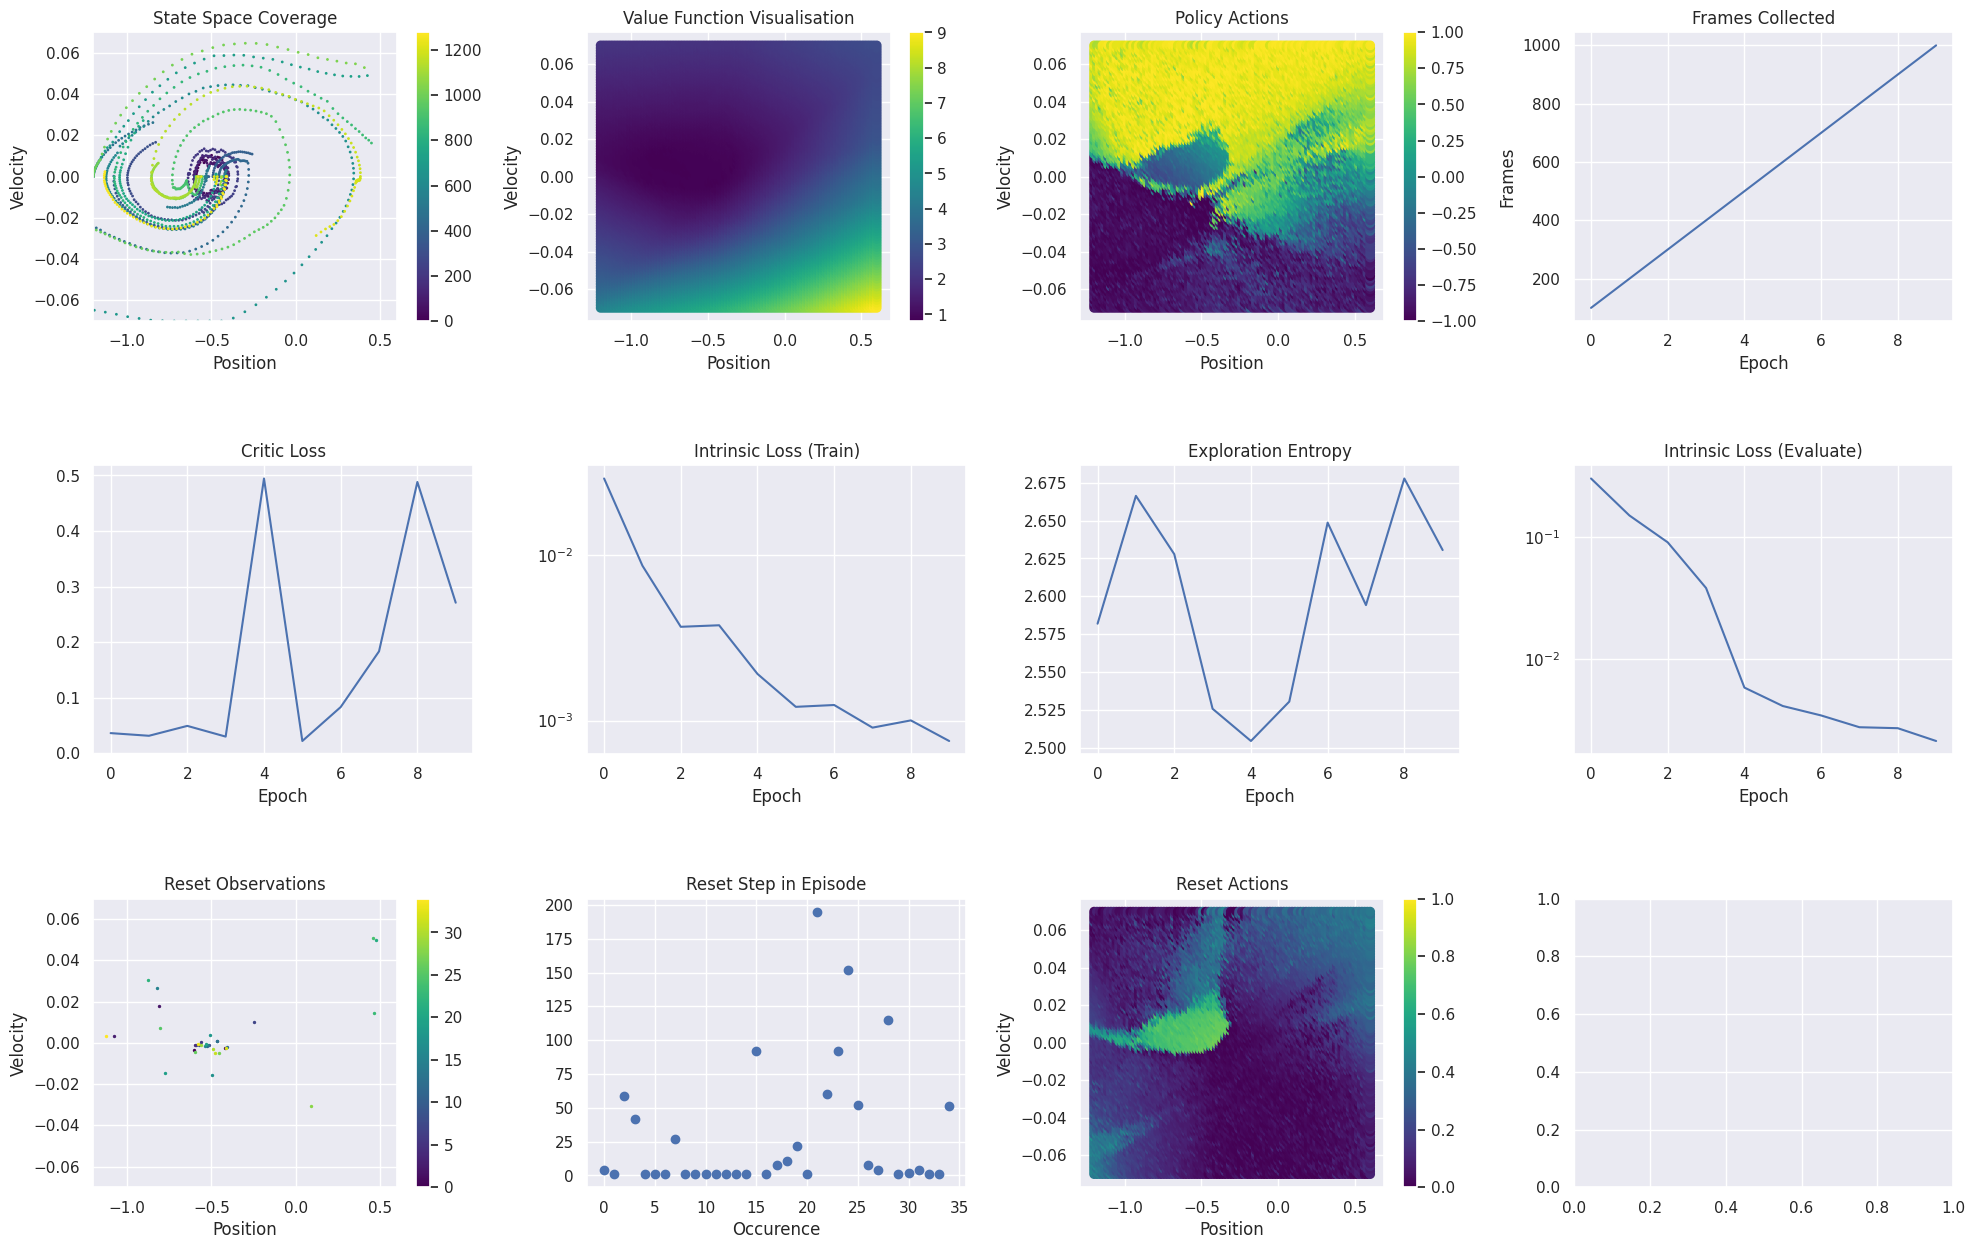

In [9]:
visualise_results(experiment)

In [25]:
experiment.logger.engine.results.keys()

dict_keys(['reset_step', 'reset_obs', 'train/wall_time', 'train/critic_loss', 'intrinsic/loss', 'intrinsic/mean_intrinsic_reward', 'intrinsic/max_intrinsic_reward', 'intrinsic/mean_extrinsic_reward', 'collector/frame', 'memory/size', 'reset_value'])

100%|██████████| 10000/10000 [01:33<00:00, 107.07it/s]
/home/markhaoxiang/Projects/part_ii_project/kitten/cats/evaluation/evaluation.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(inverse_to_env(experiment.env, states), device=experiment.device)


Entropy  2.574535527859572
Intrinsic Normalisation Mean tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>) | Std tensor(0.0081, device='cuda:0', grad_fn=<PowBackward0>)
Intrinsic 0.00013436152948997915


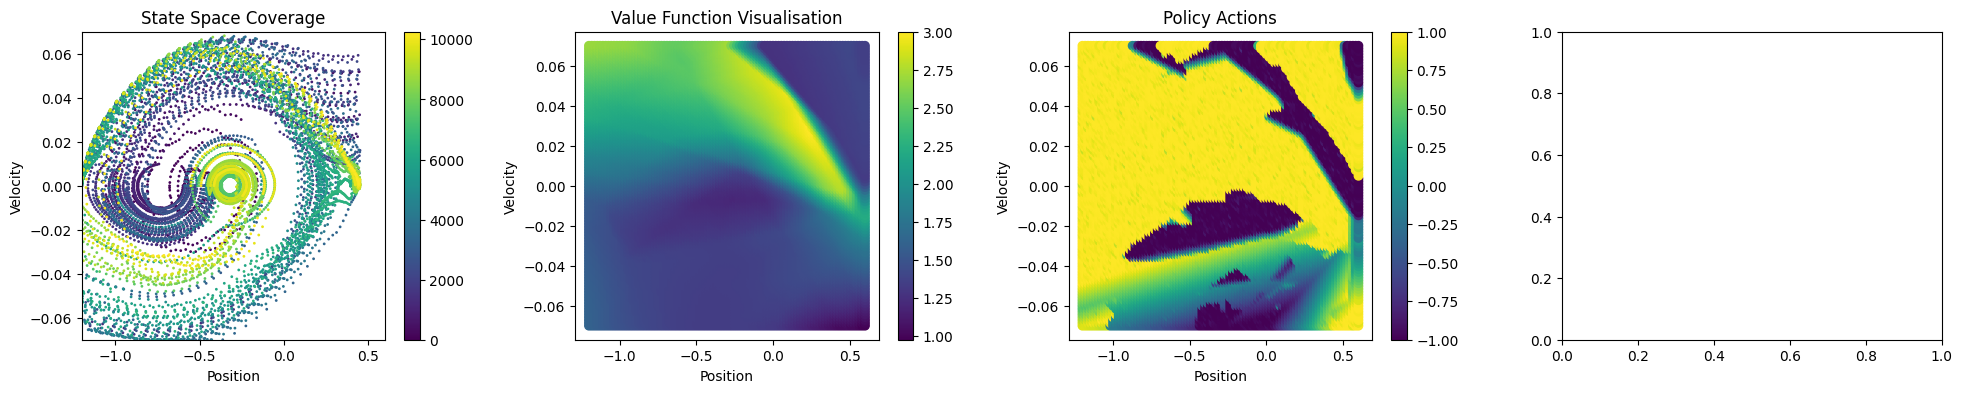

In [8]:
with initialize(version_base=None, config_path="cats/config"):
    cfg = compose(
        config_name="defaults.yaml",
        overrides=[
            "seed=0",
            "train.total_frames=10000",
        ],
    )

experiment = run(cfg)

N_ROWS, N_COL = 1, 4
fig, axs = plt.subplots(N_ROWS, N_COL)
fig.set_size_inches(N_COL * 6, N_ROWS * 4)
fig.subplots_adjust(wspace=0.3)
visualise_memory(experiment, fig, axs[0])
visualise_experiment_value_estimate(experiment, fig, axs[1], axs[2])
# visualise_teleport_targets(experiment, fig, axs[3])
print("Entropy ", entropy_memory(experiment.memory.rb))
print("Intrinsic Normalisation", experiment.intrinsic._reward_normalisation.__str__())
print("Intrinsic", evaluate_rnd(experiment))